In [1]:
import json
import pandas as pd
import numpy as np  
import os 

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Start with loading all necessary libraries
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

%matplotlib inline

In [2]:
pd.set_option('display.max_colwidth', None)

# 0. Load data 

In [3]:
# create paths 
path = '../../data'
path_audio_feats = os.path.join(path, 'audio_features.tsv')
path_playlists = os.path.join(path, 'playlists.tsv')
path_tracks = os.path.join(path, 'tracks.tsv')
path_artists = os.path.join(path, 'artists.tsv')

In [4]:
# read data from file
pd_audio_feats = pd.read_csv(path_audio_feats, sep = '\t')
pd_tracks = pd.read_csv(path_tracks, sep = '\t')
pd_playlists = pd.read_csv(path_playlists, sep = '\t')
pd_artists = pd.read_csv(path_artists, sep = '\t')

In [5]:
# print shape of these playlists
pd_playlists.shape, pd_tracks.shape, pd_audio_feats.shape, pd_artists.shape

((1412, 5), (86432, 9), (68577, 16), (67630, 6))

Ta sẽ kiểm tra các thông tin cơ bản trong các dataframe vừa được load lên ở trên 

## a. Playlist dataframe

In [6]:
pd_playlists.head(10)

playlist_id     playlist_name  \
0  37i9dQZF1DXcBWIGoYBM5M  Today's Top Hits   
1  37i9dQZF1DX0XUsuxWHRQd  Today's Top Hits   
2  37i9dQZF1DX1lVhptIYRda         RapCaviar   
3  37i9dQZF1DX10zKzsJ2jva         RapCaviar   
4  37i9dQZF1DX4JAvHpjipBk       Hot Country   
5  37i9dQZF1DX4sWSpwq3LiO       Hot Country   
6  37i9dQZF1DX4SBhb3fqCJd     ¡Viva Latino!   
7  37i9dQZF1DWXRqgorJj26U     ¡Viva Latino!   
8  37i9dQZF1DX4dyzvuaRJ0n  New Music Friday   
9  37i9dQZF1DXcF6B6QPhFDv  New Music Friday   

                                                                                          description  \
0                                                     Dua Lipa & DaBaby are on top of the Hottest 50!   
1                                                New music from Jack Harlow, Juice WRLD and Kid Cudi.   
2                                 Today's top country hits of the week, worldwide! Cover: Eric Church   
3                          Today's top Latin hits are right here, on ¡Viva Latino! Cover: Danny Ocean   
4                                      New albums from Taylor Swift, Jack Harlow, Kid Cudi, and more!   
5                                                       Relax and indulge with beautiful piano pieces   
6                                                    The pulse of R&B music today.  Cover: Ari Lennox   
7                                   Rock legends and epic songs that continue to inspire generations.   
8  The world's biggest dance hits. Music from SG Lewis & Rhye, Anabel Englund, David Guetta and more!   
9                       The newest music from grandson along with the top Rock songs you need to know   

   num_tracks  num_followers  
0          50       27084233  
1          50       13537247  
2          53        6189727  
3          50       10763311  
4         100        3694201  
5         302        6082527  
6          33        5451493  
7         145        8620894  
8          80        5556760  
9          50        4492713

In [7]:
pd_playlists.tail(10)

playlist_id                                 playlist_name  \
1402  73boXMJz9iBoXxQVFZ94r5  The official Bråvalla Festival playlist 2017   
1403  2y74Ha0ztRUcIYmqITh0D4  The official Bråvalla Festival playlist 2017   
1404  1k9jG0FUp7BcrAF1MZSabO                         International Playboy   
1405  37i9dQZF1DX2L0iB23Enbq                         International Playboy   
1406  37i9dQZF1DWVmps5U8gHNv                           National Blood Week   
1407  37i9dQZF1DX3WvGXE8FqYX                           National Blood Week   
1408  5ji4GZJpll6twskFvKxiHx      Most Listened To British Dads on Spotify   
1409  40VxbK9NqccdUDUpiUXmbp      Most Listened To British Dads on Spotify   
1410  0RTz1jFo5BXGPfI8eVf8sj                                    Viral Hits   
1411  4lgseztVwmKQ8MNETPVIny                                    Viral Hits   

                                                                                                                                                                     description  \
1402  If you travel the world and the seven seas, cashing six figure checks in all currencies, this playlist is a perfect companion for that business class seat or limo ride...   
1403                                                                                                                                                                         NaN   
1404                                                                                                                                                                         NaN   
1405                                                                                                                                             Viral, trending and taking off.   
1406         A collection of classics from the height of the folk revival to the rise of the folk rock era. Cover: <a href="spotify:artist:74ASZWbe4lXaubB36ztrGX">Bob Dylan</a>   
1407                                                                                                                                           Kick back with the queens of pop.   
1408                                                                                                                                                                         NaN   
1409                                                                                                                                                                         NaN   
1410                                                                                                                                                                         NaN   
1411                                                                                                                                                                         NaN   

      num_tracks  num_followers  
1402          23          18811  
1403          25             17  
1404          20             28  
1405         129        1402883  
1406         115         477489  
1407          70        2015059  
1408          50             14  
1409          30              7  
1410         100             57  
1411          25            124

Ý nghĩa các trường trong playlist dataframe

| Tên cột | Ý nghĩa | 
| --- | --- |
| playlist_id | Giá trị ID unique ứng với playlist | 
| playlist_name | Tên của playlist | 
| description | Chuỗi mô tả playlist |
| num_tracks | Số lượng bài hát có trong playlist |
| num_followers | Số người theo dõi playlist | 

**Nhận xét**: ta thấy tên playlists bị trùng nhau khá nhiều, thoạt nhìn có vẻ dữ liệu thu được bị nhiễu. Tuy nhiên, nếu để ý thì ID, num_tracks và num_followers của chúng không giống nhau, nên những playlist trùng tên này là những playlist *khác nhau*.

In [8]:
# check datatype of each column (we can see that all of them are of the correct type)
pd_playlists.dtypes

playlist_id      object
playlist_name    object
description      object
num_tracks        int64
num_followers     int64
dtype: object

In [9]:
# calculate statistics of numeral columns
pd_playlists[['num_tracks', 'num_followers']].describe()

num_tracks  num_followers
count  1412.000000   1.412000e+03
mean     72.672805   5.323022e+05
std      58.808214   1.356132e+06
min       0.000000   6.000000e+00
25%      42.750000   5.630000e+03
50%      55.000000   1.191595e+05
75%      94.000000   5.046452e+05
max     851.000000   2.708423e+07

**Nhận xét**: dễ dàng nhận thấy trong tập các playlist, có những playlist không chứa bài hát nào cả, ta sẽ xem đó là những playlist nào 

In [10]:
pd_playlists[pd_playlists['num_tracks'] == 0]

playlist_id           playlist_name  \
466  0NaXa68Xyo4wmMiun5Lqgm      Covered in Country   
607  0dVRyMERU2g9M4tWEfaD5B  Happy Birthday George!   
634  7iUOaMP7iKI22rBNflBwjX                   JIRMP   

                                                                                           description  \
466  Turn your commute into a karaoke party. Stay tuned for the next edition. This time: Rock Ballads.   
607                                                                                                NaN   
634                                                                                                NaN   

     num_tracks  num_followers  
466           0            171  
607           0             50  
634           0             67

Khá ngạc nhiên khi những playlist không có track nào nhưng vẫn có số lượt follower đáng kể!

In [11]:
def calculate_missing(df):
    """Return total and percentage of missing value per column"""
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [12]:
calculate_missing(pd_playlists)

Total   Percent
description      156  0.110482
num_followers      0  0.000000
num_tracks         0  0.000000
playlist_name      0  0.000000
playlist_id        0  0.000000

**Nhận xét**: ta thấy tỉ lệ missing của trường `description` khá lớn, điều này cũng dễ hiểu vì đây chỉ là trường mô tả playlist, thường bị bỏ qua khi tạo một playlist mới. Ta sẽ thay thế các vị trí bị thiếu bằng string `'None'`.

In [13]:
# fill missing value with 'None'
pd_playlists = pd_playlists.fillna('None')

## b. Track dataframe

In [14]:
pd_tracks.head()

track_id                              track_name  \
0  463CkQjx2Zk1yXoBuierM9               Levitating (feat. DaBaby)   
1  7igeByaBM0MgGsgXtNxDJ7                               positions   
2  0lx2cLdOt3piJbcaXIV74f                                  willow   
3  2Z8yfpFX0ZMavHkcIeHiO1  Monster (Shawn Mendes & Justin Bieber)   
4  6zFMeegAMYQo0mt8rXtrli                                 HOLIDAY   

              playlist_id     playlist_name  \
0  37i9dQZF1DXcBWIGoYBM5M  Today's Top Hits   
1  37i9dQZF1DXcBWIGoYBM5M  Today's Top Hits   
2  37i9dQZF1DXcBWIGoYBM5M  Today's Top Hits   
3  37i9dQZF1DXcBWIGoYBM5M  Today's Top Hits   
4  37i9dQZF1DXcBWIGoYBM5M  Today's Top Hits   

                                             artist_ids  \
0  ['6M2wZ9GZgrQXHCFfjv46we', '4r63FhuTkUYltbVAg5TQnk']   
1                            ['66CXWjxzNUsdJxJ2JdwvnR']   
2                            ['06HL4z0CvFAxyc27GXpf02']   
3  ['7n2wHs1TKAczGzO7Dd2rGr', '1uNFoZAHBGtllmzznpCI3s']   
4                            ['7jVv8c5Fj3E9VhNjxT4snq']   

                        artist_names                album_id  \
0             ['Dua Lipa', 'DaBaby']  04m06KhJUuwe1Q487puIud   
1                  ['Ariana Grande']  3jqEvfiu2ENgmgzZq27zbi   
2                   ['Taylor Swift']  2Xoteh7uEpea4TohMxjtaq   
3  ['Shawn Mendes', 'Justin Bieber']  3yVVL2EYLp8g7gT08VvYKy   
4                      ['Lil Nas X']  4EvukZrmNBiqJbs3LwOSHu   

                  album_name  track_duration_ms  
0  Levitating (feat. DaBaby)             203064  
1                  positions             172324  
2                   evermore             214706  
3                    Monster             178994  
4                    HOLIDAY             154997

Ý nghĩa của các trường trong track dataframe: 

| Tên cột | Ý nghĩa | 
| --- | --- |
| track_id | Unique ID của bài hát |
| track_name | Tên của bài hát | 
| playlist_id | ID của playlist (ở phần a.) chứa bài hát  | 
| playlist_name | Tên của playlist ứng với `playlist_id` | 
| artist_ids | IDs của các nghệ sỹ trình diễn bài hát | 
| artist_names | Tên của các nghệ sỹ trình diễn bài hát |
| album_id | ID của album chứa bài hát |
| album_name | Tên của album ứng với `album_id` | 
| track_duration_ms | Độ dài của bài hát (ms) | 

In [15]:
# check dtype of the columns (all of them are of correct type)
pd_tracks.dtypes

track_id             object
track_name           object
playlist_id          object
playlist_name        object
artist_ids           object
artist_names         object
album_id             object
album_name           object
track_duration_ms     int64
dtype: object

In [16]:
# calculate statistics of numeric columns
pd_tracks['track_duration_ms'].describe()

count    8.643200e+04
mean     2.571415e+05
std      3.158298e+05
min      4.000000e+03
25%      1.810515e+05
50%      2.160000e+05
75%      2.619060e+05
max      2.022006e+07
Name: track_duration_ms, dtype: float64

In [17]:
# check missing data
calculate_missing(pd_tracks)

Total   Percent
album_name             6  0.000069
track_name             5  0.000058
track_duration_ms      0  0.000000
album_id               0  0.000000
artist_names           0  0.000000
artist_ids             0  0.000000
playlist_name          0  0.000000
playlist_id            0  0.000000
track_id               0  0.000000

**Nhận xét**: ta thấy có 2 trường `album_name` và `track_name` có những dòng bị thiếu dữ liệu (chiếm tỉ lệ rất nhỏ). Cả 2 trường này đều là thông tin về tên bài hát/album nên cũng không quá quan trọng do chúng ta sẽ chủ yếu sử dụng các thông tin về âm thanh của bài hát để giải quyết bài toán. Ta sẽ thay các giá trị bị thiếu bằng `'None'`.

In [18]:
pd_tracks = pd_tracks.fillna('None')

## c. Audio feature dataframe

In [19]:
pd_audio_feats.head()

id  danceability  energy  key  loudness  mode  \
0  5P701xOxwxzBnXiNQ7QDKb         0.218  0.1770    2   -17.972     0   
1  6sqK5yiJ9UU1ejizantoEI         0.561  0.5530    1   -11.267     1   
2  58a6J0DhgpUYr8SUeUV5hP         0.632  0.6000    1    -9.435     1   
3  40jiZBsr1W3SG15AGU9227         0.649  0.5250    5    -7.551     0   
4  1hCPJ4xVCvTjHchrmTq4sQ         0.752  0.0972    7   -21.324     0   

   speechiness  acousticness  instrumentalness  liveness  valence    tempo  \
0       0.0428         0.870          0.908000     0.209    0.199  122.841   
1       0.0271         0.130          0.000065     0.196    0.477   81.996   
2       0.3850         0.518          0.006460     0.195    0.639  170.384   
3       0.0347         0.912          0.000111     0.121    0.603   97.808   
4       0.8930         0.794          0.000003     0.118    0.282   99.121   

                                                       analysis_url  \
0  https://api.spotify.com/v1/audio-analysis/5P701xOxwxzBnXiNQ7QDKb   
1  https://api.spotify.com/v1/audio-analysis/6sqK5yiJ9UU1ejizantoEI   
2  https://api.spotify.com/v1/audio-analysis/58a6J0DhgpUYr8SUeUV5hP   
3  https://api.spotify.com/v1/audio-analysis/40jiZBsr1W3SG15AGU9227   
4  https://api.spotify.com/v1/audio-analysis/1hCPJ4xVCvTjHchrmTq4sQ   

   time_signature  \
0               3   
1               4   
2               4   
3               4   
4               5   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          available_markets  \
0  ['AD', 'AE', 'AL', 'AR', 'AT', 'AU', 'BA', 'BE', 'BG', 'BH', 'BO', 'BR', 'BY', 'CA', 'CH', 'CL', 'CO', 'CR', 'CY', 'CZ', 'DE', 'DK', 'DO', 'DZ', 'EC', 'EE', 'EG', 'ES', 'FI', 'FR', 'GB', 'GR', 'GT', 'HK', 'HN', 'HR', 'HU', 'ID', 'IE', 'IL', 'IN', 'IS', 'IT', 'JO', 'JP', 'KW', 'KZ', 'LB', 'LI', 'LT', 'LU', 'LV', 'MA', 'MC', 'MD', 'ME', 'MK', 'MT', 'MX', 'MY', 'NI', 'NL', 'NO', 'NZ', 'OM', 'PA', 'PE', 'PH', 'PL', 'PS', 'PT', 'PY', 'QA', 'RO', 'RS', 'RU', 'SA', 'SE', 'SG', 'SI', 'SK', 'SV', 'TH', 'TN', 'TR', 'TW', 'UA', 'US', 'UY', 'VN', 'XK', 'ZA']   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    ['US']   
2  ['AD', 'AE', 'AL', 'AR', 'AT', 'AU', 'BA', 'BE', 'BG', 'BH', 'BO', 'BR', 'BY', 'CA', 'CH', 'CL', 'CO', 'CR', 'CY', 'CZ', 'DE', 'DK', 'DO', 'DZ', 'EC', 'EE', 'EG', 'ES', 'FI', 'FR', 'GB', 'GR', 'GT', 'HK', 'HN', 'HR', 'HU', 'ID', 'IE', 'IL', 'IN', 'IS', 'IT', 'JO', 'JP', 'KW', 'KZ', 'LB', 'LI', 'LT', 'LU', 'LV', 'MA', 'MC', 'MD', 'ME', 'MK', 'MT', 'MX', 'MY', 'NI', 'NL', 'NO', 'NZ', 'OM', 'PA', 'PE', 'PH', 'PL', 'PS', 'PT', 'PY', 'QA', 'RO', 'RS', 'RU', 'SA', 'SE', 'SG', 'SI', 'SK', 'SV', 'TH', 'TN', 'TR', 'TW', 'UA', 'US', 'UY', 'VN', 'XK', 'ZA']   
3  ['AD', 'AE', 'AL', 'AR', 'AT', 'AU', 'BA', 'BE', 'BG', 'BH', 'BO', 'BR', 'BY', 'CA', 'CH', 'CL', 'CO', 'CR', 'CY', 'CZ', 'DE', 'DK', 'DO', 'DZ', 'EC', 'EE', 'EG', 'ES', 'FI', 'FR', 'GB', 'GR', 'GT', 'HK', 'HN', 'HR', 'HU', 'ID', 'IE', 'IL', 'IN', 'IS', 'IT', 'JO', 'JP', 'KW', 'KZ', 'LB', 'LI', 'LT', 'LU', 'LV', 'MA', 'MC', 'MD

Ý nghĩa của các trường trong audio track dataframe: 

| Tên cột | Ý nghĩa | 
| --- | --- |
| id | ID của bài hát | 
| danceability | Mô tả bài hát có phù hợp để nhảy hay không dựa trên sự kết hợp, độ mạnh yếu của nhịp độ, nhịp điệu bài hát, có giá trị từ 0.0 - 1.0 |
| energy | Độ đo thể hiện tính chất năng lượng của bài hát thông qua cường độ. Thông thường một bài hát energetic sẽ nhanh, ồn ào, có giá trị từ 0.0 - 1.0 | 
| key | Cao độ trung bình của hát, giá trị là số nguyên, tính theo chuẩn Pitch Class Notation, nếu không có cao độ giá trị là -1 | 
| loudness | Độ to trung bình của bài hát (tính theo đơn vị dB), giá trị thường rơi vào khoảng -60.0 - 0.0 dB | 
| mode | Biểu thị thể thức (chính hoặc phụ) của một bản nhạc, loại âm hưởng mà nội dung du dương của nó được bắt nguồn. Chỉ bao gồm 2 giá trị là 1 (chính) và 0 (phụ) | 
| speechiness | Xác suất thể hiện có sự hiện diện của tiếng nói (khác với tiếng hát) trong bài hát hay không. Có giá trị trong khoảng 0.0 - 1.0, giá trị càng cao thì đây khả năng cao là bài diễn thuyết, sách nói,... | 
| acousticness | Cường độ Acoustic của bài hát hay nói cách khác là xác suất bài hát này có tính chất acoustic, có giá trị từ 0.0 - 1.0 | 
| instrumentalness | Độ đo thể hiện tính instrumental (không lời) của bài hát, có giá trị trong khoảng 0.0 - 1.0, giá trị càng cao thì càng ít giọng hát trong bài hát | 
| liveness | Độ đo thể hiện tính live (nhạc sống, có sự hiện diện của khán giả trong lúc thu âm) của bài hát, có giá trị trong khoảng 0.0 - 1.0 |
| valence | Biểu thị tính tích cực của bài hát, giá trị càng cao thì bài hát càng có tính chất tích cực (vui, phấn khởi), càng thấp thì bài hát càng buồn | 
| tempo | Nhịp độ trung bình của bài hát tính theo nhịp mỗi phút (BPM) | 
| analysis_url | URL chứa thông tin phân tích chi tiết audio của bài hát | 
| time_signature | Số chỉ nhịp của bài |
| available_markets | Các quốc gia có thể nghe bài hát này | 
| popularity | Mức độ phổ biến, yêu thích của bài (từ 0-100) |

In [20]:
# check data type of columns (we can see that all columns are of correct type)
pd_audio_feats.dtypes

id                    object
danceability         float64
energy               float64
key                    int64
loudness             float64
mode                   int64
speechiness          float64
acousticness         float64
instrumentalness     float64
liveness             float64
valence              float64
tempo                float64
analysis_url          object
time_signature         int64
available_markets     object
popularity             int64
dtype: object

In [21]:
# calculate statistics of numeric columns
numeric_cols = list(set(pd_audio_feats.columns) - set(['id', 'analysis_url', 'available_markets']))
pd_audio_feats[numeric_cols].describe()

tempo          mode    popularity        energy  acousticness  \
count  68577.000000  68577.000000  68577.000000  68577.000000  68577.000000   
mean     117.366708      0.662875     32.276813      0.536505      0.394361   
std       30.930033      0.472731     24.336507      0.287886      0.366579   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       94.478000      0.000000      2.000000      0.297000      0.034300   
50%      117.048000      1.000000     36.000000      0.568000      0.277000   
75%      136.012000      1.000000     52.000000      0.784000      0.772000   
max      230.781000      1.000000    100.000000      1.000000      0.996000   

            valence      liveness  time_signature  danceability      loudness  \
count  68577.000000  68577.000000    68577.000000  68577.000000  68577.000000   
mean       0.438724      0.189578        3.855258      0.545835    -10.758518   
std        0.256931      0.161330        0.550199      0.185030      7.033066   
min        0.000000      0.000000        0.000000      0.000000    -60.000000   
25%        0.230000      0.096900        4.000000      0.429000    -13.553000   
50%        0.419000      0.122000        4.000000      0.567000     -8.451000   
75%        0.636000      0.229000        4.000000      0.682000     -5.790000   
max        0.999000      0.997000        5.000000      0.981000      1.342000   

       instrumentalness           key   speechiness  
count      68577.000000  68577.000000  68577.000000  
mean           0.182889      5.218863      0.126904  
std            0.330683      3.562640      0.210074  
min            0.000000      0.000000      0.000000  
25%            0.000000      2.000000      0.035500  
50%            0.000218      5.000000      0.047600  
75%            0.140000      8.000000      0.091700  
max            1.000000     11.000000      0.969000

In [22]:
# check missing data
calculate_missing(pd_audio_feats)

Total  Percent
popularity             0      0.0
available_markets      0      0.0
time_signature         0      0.0
analysis_url           0      0.0
tempo                  0      0.0
valence                0      0.0
liveness               0      0.0
instrumentalness       0      0.0
acousticness           0      0.0
speechiness            0      0.0
mode                   0      0.0
loudness               0      0.0
key                    0      0.0
energy                 0      0.0
danceability           0      0.0
id                     0      0.0

## d. Artist dataframe

In [23]:
pd_artists.head()

id                   name  popularity  \
0  1EH9eSje47IiRyVsq3gfkl                  Raven          35   
1  42LOtwpoBAnVLUqPJ8gwFy         Robert Francis          35   
2  1Ec2RuosR3mXrq6Q6egvUK          Civil Olydnad           8   
3  38yLQAdUNWO2jXQs9Pnevs  Bitesize Irish Gaelic           7   
4  1YSA4byX5AL1zoTsSTlB03   Turnpike Troubadours          63   

                                                                                        genres  \
0  ['hard rock', 'metal', 'neo-trad metal', 'nwobhm', 'nwothm', 'speed metal', 'thrash metal']   
1                                                                                           []   
2                                                         ['swedish pop punk', 'swedish punk']   
3                                                                                           []   
4                                                                                 ['red dirt']   

   num_followers  monthly_listeners  
0          37148              57506  
1          17618              46087  
2            368               1509  
3           1204                514  
4         234877             950928

Ý nghĩa của các trường trong dataframe:

| Tên cột | Ý nghĩa |
| --- | --- | 
| id | ID của nghệ sĩ |
| name | Tên của nghệ sĩ | 
| popularity | Mức độ nổi tiếng/yêu thích của nghệ sĩ | 
| genres | Thể loại nhạc của artist | 
| num_followers | Số người theo dõi | 
| monthly_listeners | Số người nghe mỗi tháng | 

In [24]:
# check datatype of columns (all of them are of correct type)
pd_artists.dtypes

id                   object
name                 object
popularity            int64
genres               object
num_followers         int64
monthly_listeners     int64
dtype: object

In [25]:
# calculate statistics of numeric columns
pd_artists[['popularity', 'num_followers', 'monthly_listeners']].describe()

popularity  num_followers  monthly_listeners
count  67630.00000   6.763000e+04       6.763000e+04
mean      38.91866   1.982052e+05       7.425869e+05
std       17.97115   1.318900e+06       3.062309e+06
min        0.00000   0.000000e+00       0.000000e+00
25%       27.00000   4.080000e+02       1.245675e+04
50%       40.00000   4.654000e+03       8.478200e+04
75%       51.00000   4.380600e+04       3.865782e+05
max      100.00000   7.394012e+07       2.149540e+08

In [26]:
# check missing data 
calculate_missing(pd_artists)

Total  Percent
monthly_listeners      0      0.0
num_followers          0      0.0
genres                 0      0.0
popularity             0      0.0
name                   0      0.0
id                     0      0.0

## e. Merge các dataframes lại với nhau 

Tạm thời ta sẽ merge các dataframe trên lại với nhau, trừ dataframe artist vì:
- Việc map các artists của một bài hát sẽ dẫn đến dataframe quá lớn 
- Ta có thể EDA dataframe artist riêng 

In [27]:
# merge 
pd_track_data = pd.merge(pd_tracks, pd_audio_feats, left_on = 'track_id', right_on = 'id')
pd_full = pd.merge(pd_track_data, pd_playlists, on = 'playlist_id')

# drop duplicate column
pd_track_data = pd_track_data.drop('id', 1)
pd_full = pd_full.drop('playlist_name_y', 1)
pd_full = pd_full.drop('id', 1)

In [28]:
# print the shapes
pd_track_data.shape, pd_full.shape

((86400, 24), (86400, 27))

In [29]:
pd_full.head()

track_id                              track_name  \
0  463CkQjx2Zk1yXoBuierM9               Levitating (feat. DaBaby)   
1  7igeByaBM0MgGsgXtNxDJ7                               positions   
2  0lx2cLdOt3piJbcaXIV74f                                  willow   
3  2Z8yfpFX0ZMavHkcIeHiO1  Monster (Shawn Mendes & Justin Bieber)   
4  6zFMeegAMYQo0mt8rXtrli                                 HOLIDAY   

              playlist_id   playlist_name_x  \
0  37i9dQZF1DXcBWIGoYBM5M  Today's Top Hits   
1  37i9dQZF1DXcBWIGoYBM5M  Today's Top Hits   
2  37i9dQZF1DXcBWIGoYBM5M  Today's Top Hits   
3  37i9dQZF1DXcBWIGoYBM5M  Today's Top Hits   
4  37i9dQZF1DXcBWIGoYBM5M  Today's Top Hits   

                                             artist_ids  \
0  ['6M2wZ9GZgrQXHCFfjv46we', '4r63FhuTkUYltbVAg5TQnk']   
1                            ['66CXWjxzNUsdJxJ2JdwvnR']   
2                            ['06HL4z0CvFAxyc27GXpf02']   
3  ['7n2wHs1TKAczGzO7Dd2rGr', '1uNFoZAHBGtllmzznpCI3s']   
4                            ['7jVv8c5Fj3E9VhNjxT4snq']   

                        artist_names                album_id  \
0             ['Dua Lipa', 'DaBaby']  04m06KhJUuwe1Q487puIud   
1                  ['Ariana Grande']  3jqEvfiu2ENgmgzZq27zbi   
2                   ['Taylor Swift']  2Xoteh7uEpea4TohMxjtaq   
3  ['Shawn Mendes', 'Justin Bieber']  3yVVL2EYLp8g7gT08VvYKy   
4                      ['Lil Nas X']  4EvukZrmNBiqJbs3LwOSHu   

                  album_name  track_duration_ms  danceability  ...  liveness  \
0  Levitating (feat. DaBaby)             203064         0.702  ...    0.0674   
1                  positions             172324         0.736  ...    0.0940   
2                   evermore             214706         0.392  ...    0.1450   
3                    Monster             178994         0.652  ...    0.0828   
4                    HOLIDAY             154997         0.810  ...    0.0832   

   valence    tempo  \
0    0.915  102.977   
1    0.675  144.005   
2    0.529   81.112   
3    0.549  145.765   
4    0.837  151.947   

                                                       analysis_url  \
0  https://api.spotify.com/v1/audio-analysis/463CkQjx2Zk1yXoBuierM9   
1  https://api.spotify.com/v1/audio-analysis/7igeByaBM0MgGsgXtNxDJ7   
2  https://api.spotify.com/v1/audio-analysis/0lx2cLdOt3piJbcaXIV74f   
3  https://api.spotify.com/v1/audio-analysis/2Z8yfpFX0ZMavHkcIeHiO1   
4  https://api.spotify.com/v1/audio-analysis/6zFMeegAMYQo0mt8rXtrli   

   time_signature  \
0               4   
1               4   
2               4   
3               4   
4               4   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          available_markets  \
0                          ['AD', 'AE', 'AL', 'AR', 'AU', 'BA', 'BE', 'BG', 'BH', 'BO', 'BR', 'BY', 'CA', 'CL', 'CO', 'CR', 'CY', 'CZ', 'DK', 'DO', 'DZ', 'EC', 'EE', 'EG', 'ES', 'FI', 'FR', 'GB', 'GR', 'GT', 'HK', 'HN', 'HR', 'HU', 'ID', 'IE', 'IL', 'IN', 'IS', 'IT', 'JO', 'JP', 'KW', 'KZ', 'LB', 'LI', 'LT', 'LU', 'LV', 'MA', 'MC', 'MD', 'ME', 'MK', 'MT', 'MX', 'MY', 'NI', 'NO', 'NZ', 'OM', 'PA', 'PE', 'PH', 'PL', 'PS', 'PT', 'PY', 'QA', 'RO', 'RS', 'RU', 'SA', 'SE', 'SG', 'SI', 'SK', 'SV', 'TH', 'TN', 'TR', 'TW', 'UA', 'US', 'UY', 'VN', 'XK', 'ZA']   
1                                                                                                                                                                                                                                                                                              

## 1. Kiểm tra thông tin DataFrame thu thập được.

In [30]:
# print information of the full dataframe
pd_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86400 entries, 0 to 86399
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   track_id           86400 non-null  object 
 1   track_name         86400 non-null  object 
 2   playlist_id        86400 non-null  object 
 3   playlist_name_x    86400 non-null  object 
 4   artist_ids         86400 non-null  object 
 5   artist_names       86400 non-null  object 
 6   album_id           86400 non-null  object 
 7   album_name         86400 non-null  object 
 8   track_duration_ms  86400 non-null  int64  
 9   danceability       86400 non-null  float64
 10  energy             86400 non-null  float64
 11  key                86400 non-null  int64  
 12  loudness           86400 non-null  float64
 13  mode               86400 non-null  int64  
 14  speechiness        86400 non-null  float64
 15  acousticness       86400 non-null  float64
 16  instrumentalness   864

In [31]:
# Kiểm tra và bỏ giá trị trùng lặp
pd_full = pd_full.drop_duplicates()
pd_full.shape

(86350, 27)

## 2. Phân tích và khám phá dữ liệu (EDA)

### Nhóm câu hỏi 1: Liên quan đến playlist.

#### Câu hỏi 1: Số lượng bài hát và lượt theo dõi của mỗi playlist phân bố như thế nào?

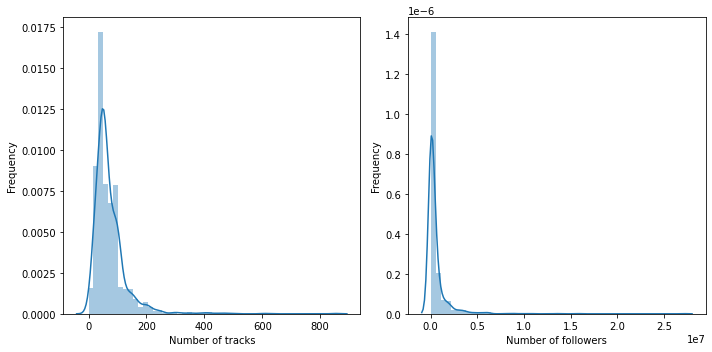

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.distplot(pd_playlists['num_tracks'].values, ax = ax[0])
sns.distplot(pd_playlists['num_followers'].values, ax = ax[1])

ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Number of tracks')
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Number of followers')

fig.tight_layout()

In [33]:
fig = px.box(pd_playlists, x="num_tracks", points="all", title="Distribution of number of tracks in each playlist")
fig.show()

In [34]:
fig = px.box(pd_playlists, x="num_followers", points="all", title="Distribution of number of followers of each playlist")
fig.show()

**Nhận xét**: 
- Cả số lượng bài hát & (đặc biệt là) số lượt theo dõi đều có phân bố lệch trái 
- Số lượng bài hát của mỗi playlist tập trung ở khoảng dưới 100 bài (giá trị median khoảng 55), một số lượng vừa đủ, đảm bảo playlist không quá dài và không quá ngắn (bài toán recommend bài hát để tiếp tục playlist có thể gợi ý số bài hát ở khoảng vài chục để phù hợp với hầu hết các playlist)
- Số lượt theo dõi có sự chênh lệch rất khác biệt giữa các playlist. Trong khi hầu hết các playlist có số followers nhỏ hơn 500k, những playlist hot nhất có số lượt theo dõi cao gấp rất nhiều lần (chủ yếu gấp 15 lần), playlist nổi tiếng nhất có lượt followers hơn 27M, tức gấp hơn 54 lần những playlist thông thường!

#### Câu hỏi 2: Hãy liệt kê các tên playlist có số lượng người theo dõi nhiều nhất (thông tin này sẽ có lợi cho quá trình đề xuất bài hát)

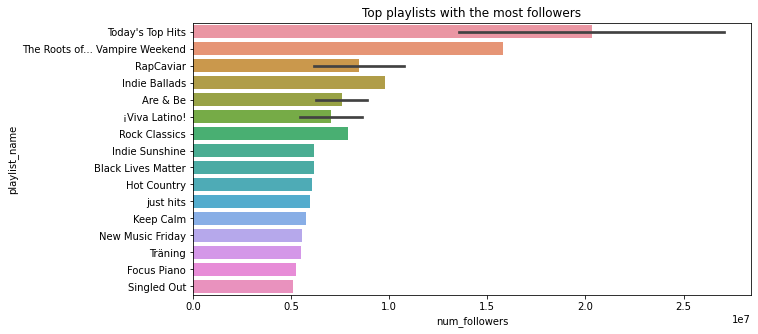

In [35]:
temp_pd = pd_playlists.sort_values(by=['num_followers'], ascending=False)
top_num = 20
plt.figure(figsize=(10, 5))
ax = sns.barplot(x="num_followers", y="playlist_name", data=temp_pd[:top_num])
_ = ax.set_title('Top playlists with the most followers')

**Nhận xét**: 
- Ta thấy playlist có nhiều người theo dõi nhất là `Today's Top Hits`, có thể lý giải bởi gần như mọi người đều muốn cập nhật những bài hát mới và nổi tiếng nhất **theo ngày**.
- Những playlist tiếp theo nằm trong top là những playlist chia theo **thể loại nhạc** như Rap, R&B (Are & Be), Rock, ...
- Trong top những playlist này có playlist `Black Lives Matter`, thể hiện phong trào đấu tranh cho người da đen gần đây ở Mỹ. Điều này cho ta thấy rõ ràng âm nhạc là một phần rất gần gũi của cuộc sống con người, xu hướng âm nhạc phản ánh những gì đang diễn ra ngoài xã hội.

#### Câu hỏi 3: Hãy liệt kê các tên playlist có số lượng tracks nhiều nhất.

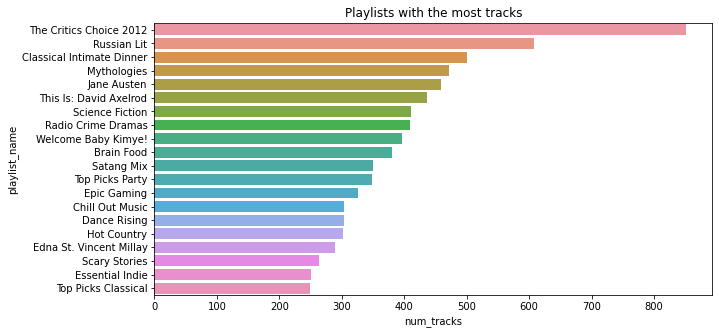

In [36]:
temp_pd = pd_playlists.sort_values(by=['num_tracks'], ascending=False)
top_num = 20
plt.figure(figsize=(10, 5))
ax = sns.barplot(x="num_tracks", y="playlist_name", data=temp_pd[:top_num])
_ = ax.set_title('Playlists with the most tracks')

In [37]:
temp_pd.head(20)

playlist_id              playlist_name  \
1369  2fC7gpl3V9MmCc8gBPHc66    The Critics Choice 2012   
888   37i9dQZF1DX0yHwYvqyUJQ                Russian Lit   
912   1M2abQkxCwrLjzLGgKWnDP  Classical Intimate Dinner   
885   37i9dQZF1DWTJSgpZmw7H2                Mythologies   
878   37i9dQZF1DXc6li3e9oatQ                Jane Austen   
336   37i9dQZF1DXb85CZUwGLzX     This Is: David Axelrod   
893   37i9dQZF1DX8d1cgbQqKFy            Science Fiction   
886   37i9dQZF1DWVrSKB2Pc3PY         Radio Crime Dramas   
626   0tkdz9yYluhlxVE9BuJOPm        Welcome Baby Kimye!   
129   37i9dQZF1DX6GJXiuZRisr                 Brain Food   
521   37i9dQZF1DX0SM0LYsmbMT                 Satang Mix   
1236  37i9dQZF1DX7K31D69s4M1            Top Picks Party   
996   37i9dQZF1DX3Ogo9pFvBkY                Epic Gaming   
1272  37i9dQZF1DX9sIqqvKsjG8            Chill Out Music   
116   37i9dQZF1DX6VdMW310YC7               Dance Rising   
5     37i9dQZF1DX4sWSpwq3LiO                Hot Country   
853   37i9dQZF1DWZxkZk4wnQ5T    Edna St. Vincent Millay   
890   37i9dQZF1DX60lVXkfYly8              Scary Stories   
1004  37i9dQZF1DXcgZcN2HVMoe            Essential Indie   
1233  37i9dQZF1DWZd79rJ6a7lp        Top Picks Classical   

                                                                                                                                                                           description  \
1369                                                                                                                                                                              None   
888                                        Learn Italian with a collection of audio courses that will take you from beginner lessons and travel necessities to advanced conversations.   
912   Lend some gravitas to the moment with the complete works of Vincenzo Bellini, featuring acclaimed recordings of his entire operatic oeuvre and large scale sacred choral pieces.   
885                        Learn French with a collection of audio courses that will take you from beginner lessons to advanced conversations and even French literature appreciation.   
878           Learn Spanish with a collection of audio courses that will take you from beginner lessons to advanced conversations – featuring essential travel phrases and vocabulary!   
336                                                                                                                     Silly-walk your way through the entire Monty Python catalogue.   
893                                                                                     Dive into the works of Noam Chomsky, beginning with his latest 2014 release, When Elites Fail.   
886                                                                        Learn German with a collection of audio courses that will take you from beginner to advanced conversations.   
626                                                                                          A collection of live, exclusive performances from the most exciting artists in the world.   
129                                                                       Dark & moody progressive house <a href="spotify:genre:edm_dance">& electronic</a> on the late night highway.   
521                                                                                                          Chill instrumental beats. Artwork: Gizem Winter & Marcel Schöffel for DAO   
1236                                                                                                                                        A calm piano soundtrack to all activities.   
996                                                                                                                                        Relax and unwind with chill, ambient music.   
1272                                                                                                                                         A soft musical backdrop for your

**Nhận xét**: playlist có nhiều bài hát nhất là `The Critics Choice 2012`, có thể đây là playlist tập hợp những bài hát được lựa chọn để nghe trong năm 2012. Dựa vào description của các playlists, ta có thể thấy những playlist chứa nhiều tracks nhất là tập hợp những audio để học một ngôn ngữ nào đó (Italian, Chinese, German, ...) hoặc là tập hợp những công trình/tác phẩm của một tác giả nào đó, ...

#### Câu hỏi 4: Số lượng tracks của 20 playlist hot nhất 

In [38]:
top_playlist = pd_playlists.sort_values(by=['num_followers'], ascending=False).head(20)
percentage = top_playlist['num_tracks'].value_counts(normalize=True)
tmp_df = pd.DataFrame({
    'Percentage': percentage.values,
    'Number of tracks': percentage.index
})
tmp_df

Percentage  Number of tracks
0         0.30               100
1         0.20                50
2         0.05                53
3         0.05               145
4         0.05                80
5         0.05               302
6         0.05                77
7         0.05                75
8         0.05               105
9         0.05                99
10        0.05               130
11        0.05                33

In [39]:
px.pie(tmp_df, names='Number of tracks', values='Percentage', title="Number of tracks in top playlists")

**Nhận xét**: Dựa vào bảng và biểu đồ trên, ta thấy hầu hết các top playlists có số bài hát nhỏ hơn 100 bài. Những playlist có nhiều bài hát hơn cũng chỉ có nhiều nhất khoảng 300 bài hát. Điều này phần nào thể hiện xu thế những playlist phổ biến có số lượng track không quá nhiều.

#### Câu hỏi 5: Các từ được sử dụng nhiều nhất để đặt tên playlist và mô tả playlist

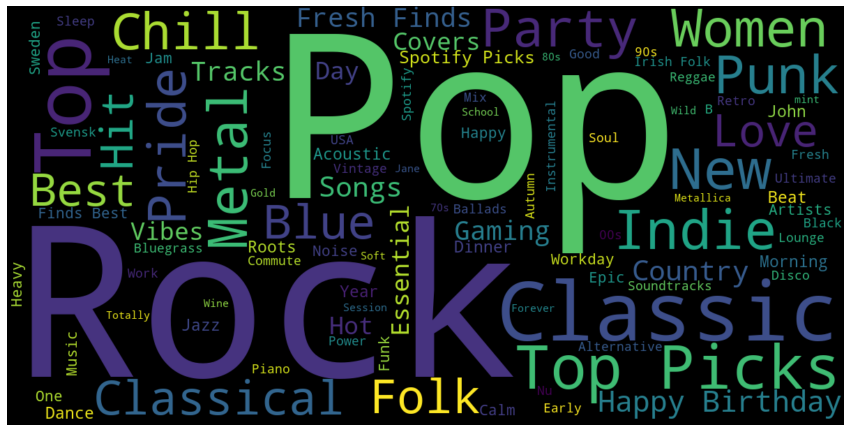

In [40]:
titles = " ".join(pd_playlists['playlist_name'])

# Create stopword list:
stopwords = set(STOPWORDS)

# Create and generate a word cloud image:
wordcloud = WordCloud(width=1200, height=600, stopwords=stopwords, max_words=100).generate(titles)

# Display the generated image:
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**Nhận xét**: 
Dễ dàng nhận thấy những từ phổ biến nhất trong tên bài hát là những từ chỉ **thể loại** nhạc như *Rock, Pop, Metal, Classical, ...* hay những từ thể hiện **mục đích** của playlist như *Happy Birthday, Pride, Party, Work, Chill, ...* Những từ này được chọn vì nó thể hiện rõ ràng theme của playlist, dễ hình dung nội dung playlist khi đọc.

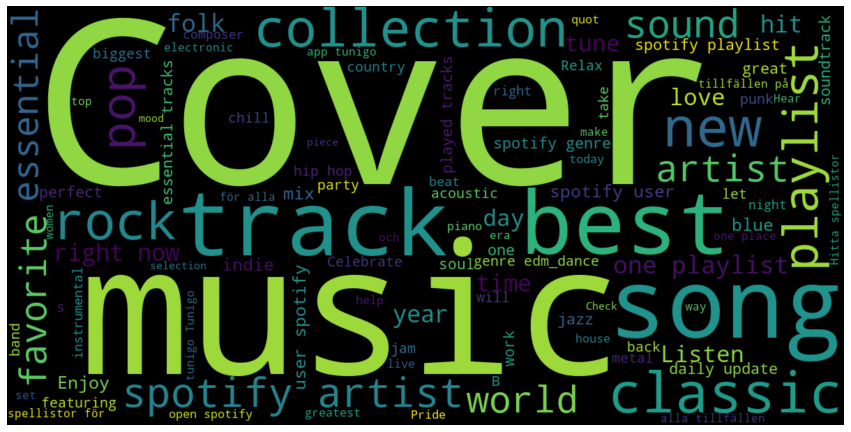

In [41]:
msk = pd_playlists['description'] != "None"
descriptions = " ".join(pd_playlists['description'][msk])

# Create stopword list:
stopwords.update(["href"])

# Create and generate a word cloud image:
wordcloud = WordCloud(width=1200, height=600, stopwords=stopwords, max_words=100).generate(descriptions)

# Display the generated image:
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**Nhận xét:**
Khác với những từ trong tên playlist, những từ phổ biến nhất để mô tả playlist là những từ mô tả **tập hợp, bài hát** như *collection, playlist, track, music, song* và những từ chỉ **thể loại** như *cover, rock, pop, classic, ...*

### Nhóm câu hỏi 2: Liên quan đến tác giả bài hát (artist) và album (album)

#### Câu hỏi 1: Hãy liệt kê các nghệ sĩ (artist) và album có số lượng tracks nhiều nhất. 

In [42]:
temp_df = pd_full[['artist_names']]
temp_df['artist_names'] = temp_df['artist_names'].apply(lambda x : x[1:-1].split(','))
temp_df = temp_df.explode('artist_names')

top_num = 20
temp_df = temp_df['artist_names'].value_counts()[:top_num]

<ipython-input-42-cae76385973d>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



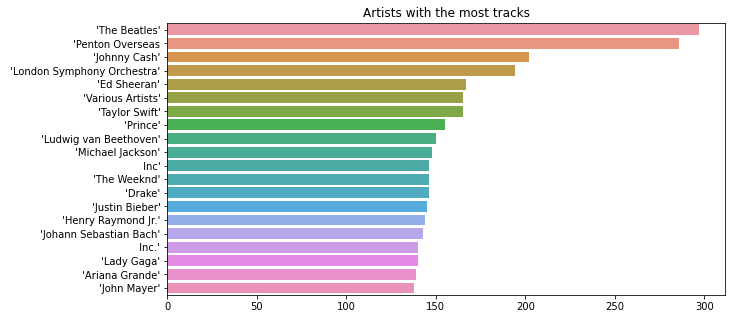

In [43]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x = temp_df.values, y= temp_df.index)
_ = ax.set_title('Artists with the most tracks')

**Nhận xét**: Những nghệ sĩ có nhiều bài hát nhất bao gồm cả những nghệ sĩ trẻ (Talor Swift, Ed Sheeran, ...), những nghệ sĩ lâu năm (The Beatles, Johnny Cash), công ty phát hành sách (Penton Overseas), nhà soạn nhạc (Beethoven). Đây đều là những tên tuổi hàng đầu được nhiều người biết đến.

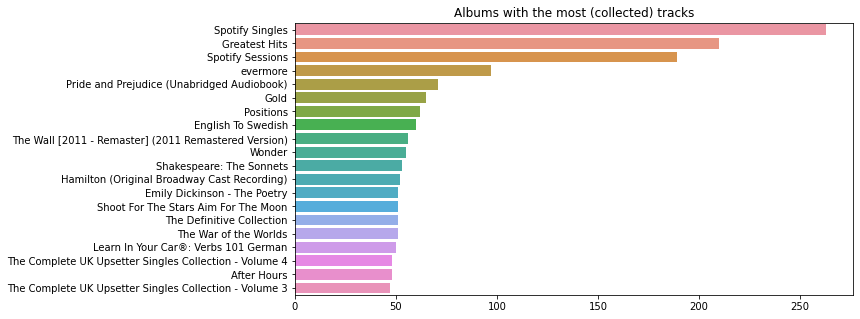

In [44]:
temp_df = pd_full[['album_name']]
top_num = 20
temp_df = temp_df['album_name'].value_counts()[:top_num]

plt.figure(figsize=(10, 5))
ax = sns.barplot(x = temp_df.values, y= temp_df.index)
_ = ax.set_title('Albums with the most (collected) tracks')

#### Câu hỏi 2: Kiểm tra mức độ phổ biến/nổi tiếng của các nghệ sĩ 

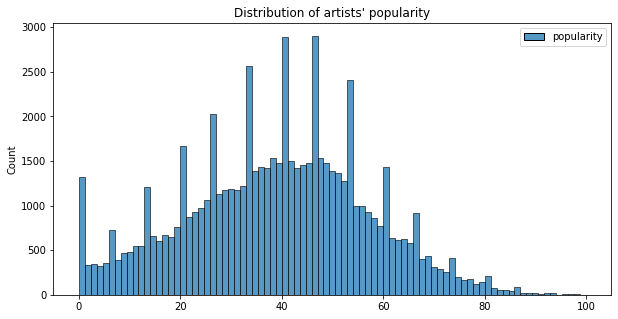

In [45]:
plt.figure(figsize=(10, 5))
_ = sns.histplot(pd_artists[['popularity']]).set_title("Distribution of artists' popularity")

**Nhận xét:** ta thấy distribution mức độ nổi tiếng/yêu thích của các nghệ sĩ có hình dạng gần chuẩn.

#### Câu hỏi 3: Genre phổ biến mà các nghệ sĩ theo đuổi 

In [46]:
genres = pd_artists['genres'].apply(lambda x: x[1:-1].split(', ')).explode()
top_num = 20
genres = genres.value_counts()[:top_num]
genres

                           21599
'rock'                      1099
'dance pop'                 1057
'pop'                       1004
'pop dance'                  831
'modern rock'                793
'indie folk'                 789
'classical performance'      775
'edm'                        771
'indie rock'                 734
'rap'                        726
'electro house'              725
'pop rap'                    722
'electropop'                 709
'hip hop'                    656
'folk rock'                  652
'pop rock'                   627
'soft rock'                  624
'mellow gold'                604
'country rock'               596
Name: genres, dtype: int64

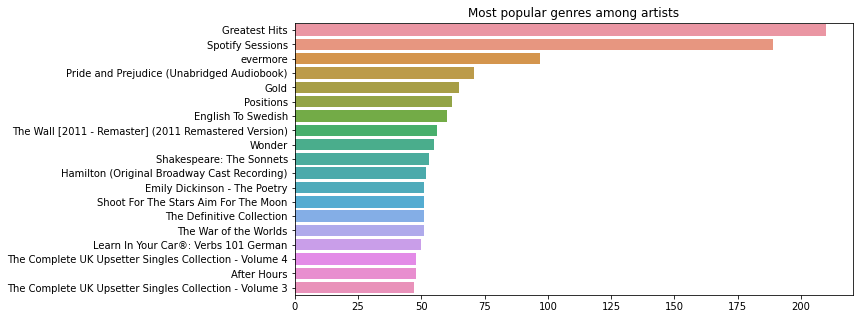

In [47]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x = temp_df.values[1:], y= temp_df.index[1:])
_ = ax.set_title('Most popular genres among artists')

**Nhận xét:** ta có thể thấy những genre phổ biến nhất là những (biến thể) của các thể loại *pop*, *rock*, *dance*, *rap*, ...

### Nhóm câu hỏi 3: Liên quan đến các bài hát.

#### Câu hỏi 0: Bài hát nào xuất hiện trong nhiều playlist nhất?

In [48]:
id_to_name = dict(zip(pd_full['track_id'], pd_full['track_name']))
id_to_artist = dict(zip(pd_full['track_id'], pd_full['artist_names']))
most_freq_ids = pd_full['track_id'].value_counts().head(10)
tmp_df = pd.DataFrame({
    'track_id': most_freq_ids.index,
    'track_name': [id_to_name[idx] for idx in most_freq_ids.index],
    'frequency': most_freq_ids.values,
    'artists': [id_to_artist[idx] for idx in most_freq_ids.index]
})
tmp_df

track_id                                 track_name  \
0  54bFM56PmE4YLRnqpW6Tha                             Therefore I Am   
1  0VjIjW4GlUZAMYd2vXMi3b                            Blinding Lights   
2  6zFMeegAMYQo0mt8rXtrli                                    HOLIDAY   
3  3tjFYV6RSFtuktYl3ZtYcq                     Mood (feat. iann dior)   
4  5vGLcdRuSbUhD8ScwsGSdA                                    Whoopty   
5  45bE4HXI0AwGZXfZtMp8JR                         you broke me first   
6  7hxHWCCAIIxFLCzvDgnQHX  Lemonade (feat. Gunna, Don Toliver & NAV)   
7  1tkg4EHVoqnhR6iFEXb60y                    What You Know Bout Love   
8  0lizgQ7Qw35od7CYaoMBZb                              Santa Tell Me   
9  35mvY5S1H3J2QZyna3TFe0                                  positions   

   frequency                                            artists  
0         37                                  ['Billie Eilish']  
1         36                                     ['The Weeknd']  
2         33                                      ['Lil Nas X']  
3         31                          ['24kGoldn', 'iann dior']  
4         27                                             ['CJ']  
5         27                                     ['Tate McRae']  
6         26  ['Internet Money', 'Gunna', 'Don Toliver', 'NAV']  
7         26                                      ['Pop Smoke']  
8         26                                  ['Ariana Grande']  
9         26                                  ['Ariana Grande']

**Nhận xét:** những bài hát ở trên đều là những bài hát *mới* và *phổ biến*, đến từ những nghệ sĩ *nổi tiếng*. Có thể đây là lý do chúng được thêm vào nhiều playlists khác nhau.

#### Câu hỏi 1: Thời lượng của các bài hát được phân bố như thế nào?

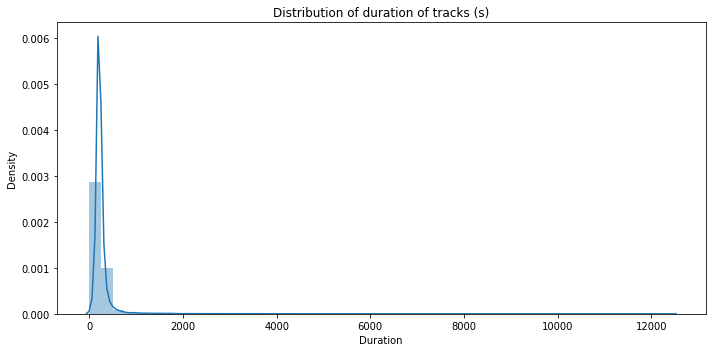

In [49]:
fig, ax = plt.subplots(figsize=(10, 5))
duration = pd_full['track_duration_ms'] / 1000
sns.distplot(duration.values, ax = ax)

ax.set_title('Distribution of duration of tracks (s)')

ax.set_ylabel('Density')
ax.set_xlabel('Duration')

fig.tight_layout()

In [50]:
duration.describe()

count    86350.000000
mean       254.086963
std        226.711725
min          4.000000
25%        181.050500
50%        216.000000
75%        261.853000
max      12456.045000
Name: track_duration_ms, dtype: float64

**Nhận xét**:
Ta thấy hầu hết các bài hát đều có độ dài dưới 250s (khoảng 4p)

#### Câu hỏi 2: Các thuộc tính liên quan đến tâm trạng bài hát (Danceability, Valence, Energy, Tempo) được phân bố như thế nào?

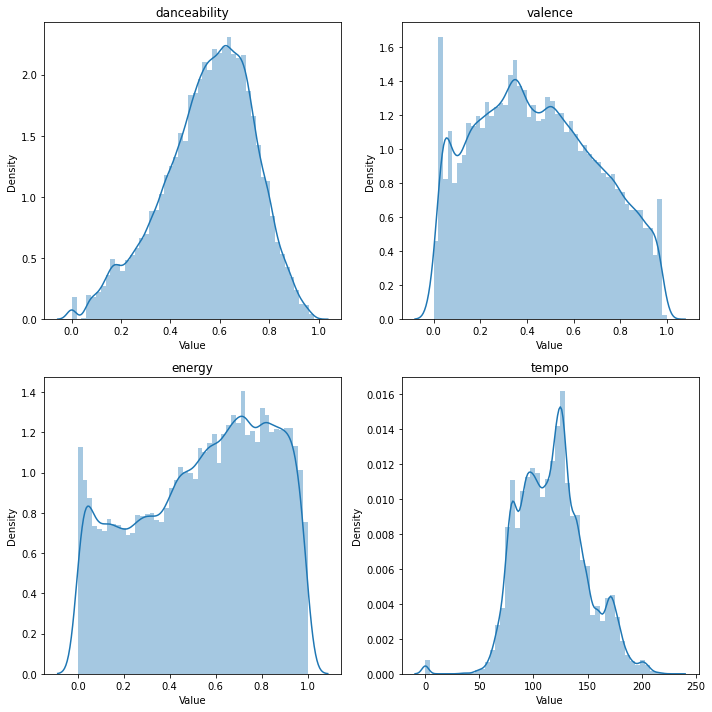

In [51]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

sns.distplot(pd_full['danceability'].values, ax = ax[0][0])
sns.distplot(pd_full['valence'].values, ax = ax[0][1])
sns.distplot(pd_full['energy'].values, ax = ax[1][0])
sns.distplot(pd_full['tempo'].values, ax = ax[1][1])

ax[0][0].set_title('danceability')
ax[0][1].set_title('valence')
ax[1][0].set_title('energy')
ax[1][1].set_title('tempo')

for i in range(2):
    for j in range(2):
        ax[i][j].set_ylabel('Density')
        ax[i][j].set_xlabel('Value')

fig.tight_layout()

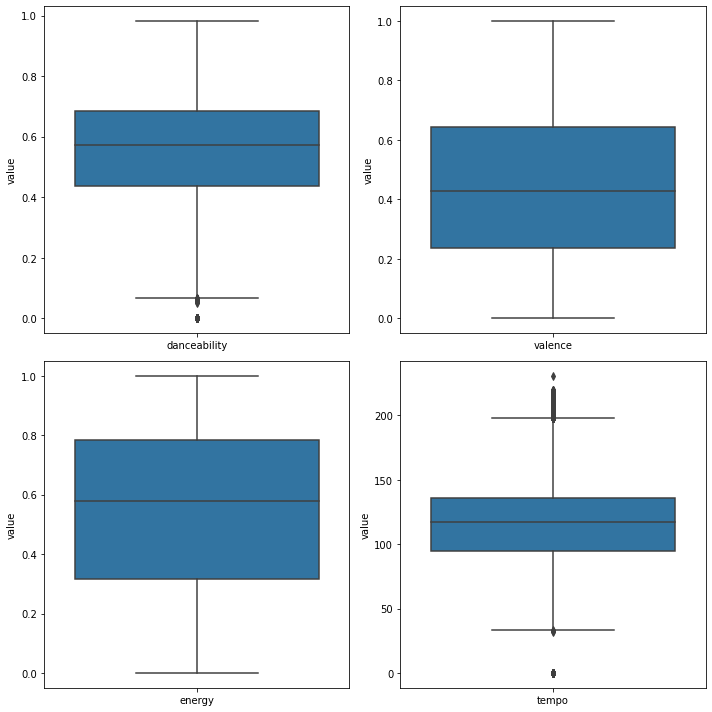

In [52]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

sns.boxplot(data=pd_full[['danceability']], ax = ax[0][0])
sns.boxplot(data=pd_full[['valence']], ax = ax[0][1])
sns.boxplot(data=pd_full[['energy']], ax = ax[1][0])
sns.boxplot(data=pd_full[['tempo']], ax = ax[1][1])

for i in range(2):
    for j in range(2):
        ax[i][j].set_ylabel('value')

fig.tight_layout()

**Nhận xét**:
- Chỉ có thuộc tính `danceability` có phân bố gần chuẩn, các thuộc tính khác `valence`, `energy`, `tempo` có distribution phức tạp với nhiều modes 
- Thuộc tính `tempo` có scale lớn hơn nhiều so với các thuộc tính còn lại, nên cần chú ý trong quá trình xây dựng mô hình
- Cả 4 thuộc tính trên đều có các giá trị nằm rải rác trong miền giá trị của chúng, thể hiện sự đa dạng và phân bố khá liên tục của các bài hát.

#### Câu hỏi 3: Các thuộc tính liên quan đến đặc điểm bài hát (Loudness, Speechiness, Instrumentalness) được phân bố như thế nào?

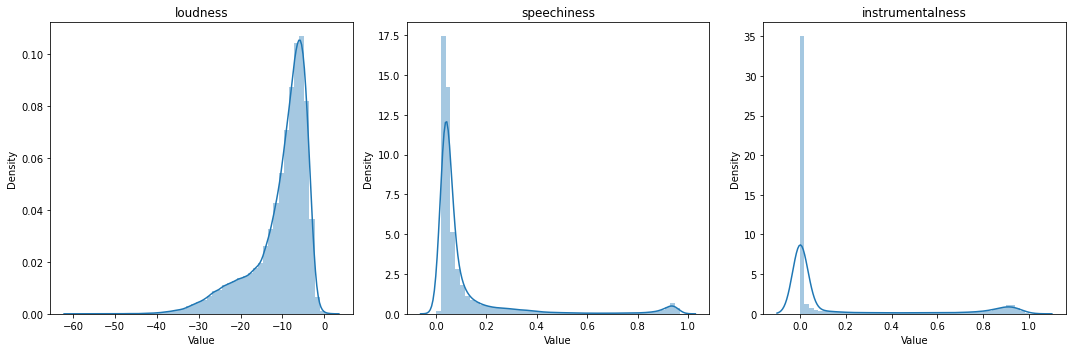

In [53]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.distplot(pd_full['loudness'].values, ax = axes[0])
sns.distplot(pd_full['speechiness'].values, ax = axes[1])
sns.distplot(pd_full['instrumentalness'].values, ax = axes[2])

axes[0].set_title('loudness')
axes[1].set_title('speechiness')
axes[2].set_title('instrumentalness')

for i in range(3):
    axes[i].set_ylabel('Density')
    axes[i].set_xlabel('Value')

fig.tight_layout()

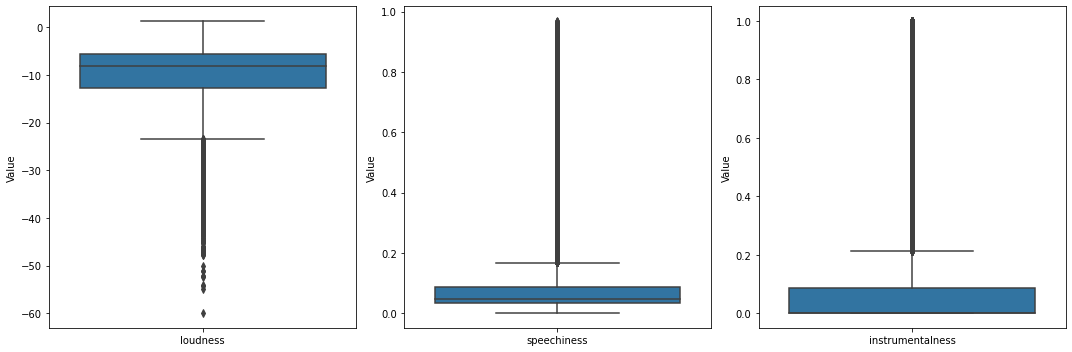

In [54]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.boxplot(data=pd_full[['loudness']], ax = axes[0])
sns.boxplot(data=pd_full[['speechiness']], ax = axes[1])
sns.boxplot(data=pd_full[['instrumentalness']], ax = axes[2])

for i in range(3):
    axes[i].set_ylabel('Value')

fig.tight_layout()

**Nhận xét:**
- Ta nhận thấy chỉ có thuộc tính `loudness` là có phân bố khá liên tục, các điểm dữ liệu không quá tập trung tại một vùng nào đó.
- Khác với các thuộc tính ở trên, `speechiness` và `instrumentalness` có distribution với 2 cụm điểm tách biệt. Điều này phù hợp với ý nghĩa của các trường này: *speechiness* thể hiện một track là bài hát hay bài diễn thuyết, *instrumentalness* thể hiện một track có lời hay không lời. Mặc dù đây là 2 biến liên tục nhưng trong quá trình xây dựng mô hình, ta có thể xét ngưỡng để biến 2 biến này thành dạng rời rạc.

#### Câu hỏi 4: Các thuộc tính liên quan đến nội dung bài hát (Liveness, Acousticness) được phân bố như thế nào?

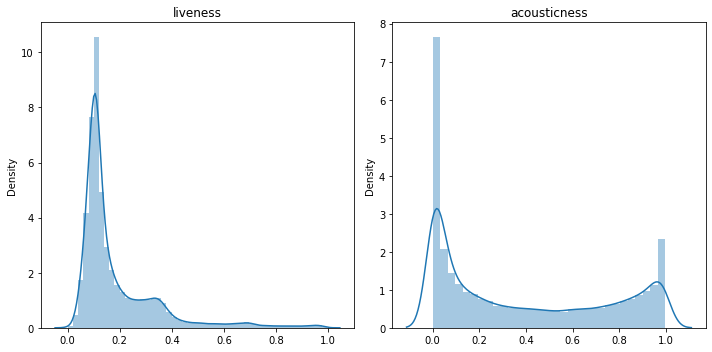

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.distplot(pd_full['liveness'].values, ax = ax[0])
sns.distplot(pd_full['acousticness'].values, ax = ax[1])

ax[0].set_title('liveness')
ax[1].set_title('acousticness')

for i in range(2):
    ax[i].set_ylabel('Density')

fig.tight_layout()

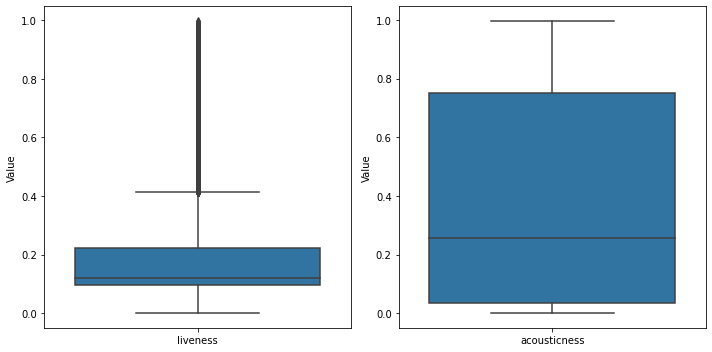

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.boxplot(data=pd_full[['liveness']], ax = ax[0])
sns.boxplot(data=pd_full[['acousticness']], ax = ax[1])

for i in range(2):
    ax[i].set_ylabel('Value')

fig.tight_layout()

**Nhận xét**:
- Thuộc tính `liveness` có phân bố tập trung hơn so với thuộc tính `acousticness`
- `acousticness` có distribution với 2 mode 0 và 1, có lẽ phản ánh sự tách biệt giữa những bài hát thu âm và những bài hát được hát theo phong cách acoustic.

#### Câu hỏi 5: Mức độ phổ biến/yêu thích của các bài hát phân bố ra sao 

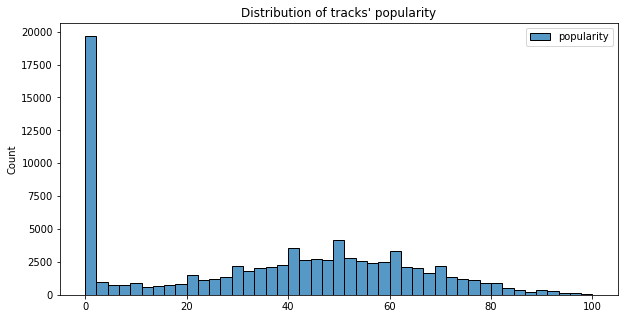

In [57]:
plt.figure(figsize=(10, 5))
_ = sns.histplot(pd_full[['popularity']]).set_title("Distribution of tracks' popularity")

**Nhận xét**: Dựa vào histogram trên, ta thấy mức độ yêu thích của các track có phân bố dạng hình chuông. Tuy nhiên, số lượng bài có độ yêu thích bằng 0 chiếm số lượng khá lớn. Nguyên nhân có thể do đây là những bài hát mới, chưa có đủ thông tin để đánh giá mức độ yêu thích, phổ biến của chúng. 

#### Câu hỏi 6: Tương quan giữa các thuộc tính trên (Danceability, Valence, Energy, Tempo, Loudness, Speechiness, Instrumentalness, Liveness, Acousticness, Duration, Popularity) là như thế nào?

In [58]:
temp_df = pd_full[['popularity', 'track_duration_ms', 'liveness', 'acousticness', 'loudness', 'speechiness', 'instrumentalness', 'danceability', 'valence', 'energy', 'tempo']]

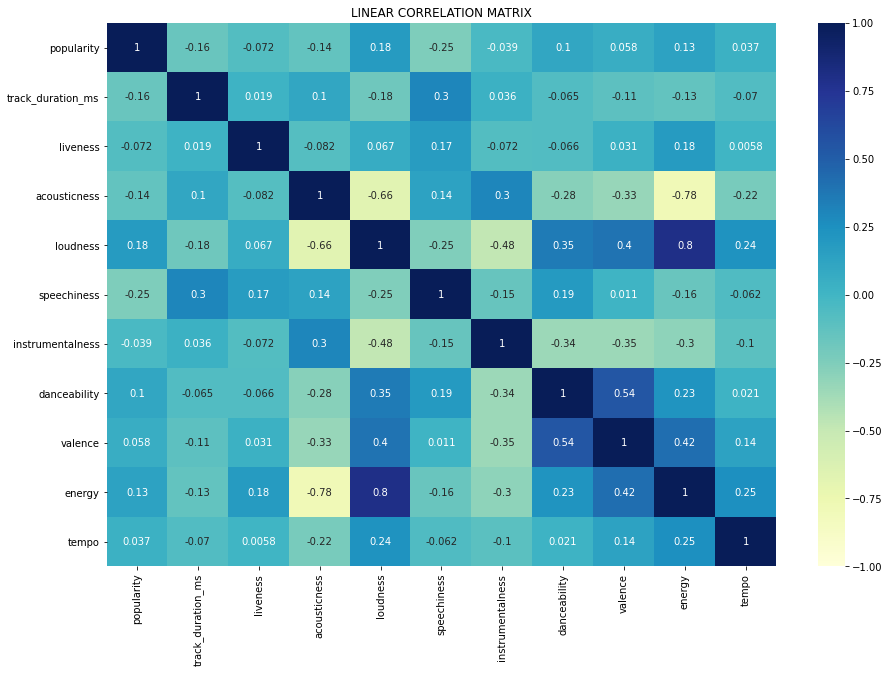

In [59]:
# Plot linear correlation matrix
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(temp_df.corr(), annot=True, cmap='YlGnBu', vmin=-1, vmax=1, center=0, ax=ax)
plt.title('LINEAR CORRELATION MATRIX')
plt.show()

**Nhận xét**: dựa vào heatmap trên, ta có thể đưa ra một vài nhận xét về tương quan giữa các biến:
- `valence`, `danceability` và `energy` có mối tương quan dương (khá hợp lý vì đây là các thuộc tính thể hiện tính "nhún nhảy", tích cực và năng lượng của một bài hát)
- `track_duration_ms` và `speechiness` có mối tương quan dương (0.3). Điều này có thể giải thích như sau: bài nói/thuyết trình (có speechiness lớn) thường dài hơn những bài hát thông thường.
- `acousticness` có mối tương quan âm với `loudness` và `energy`: những bài hát acoustic thường không quá lớn tiếng và mang tính thư giãn, cảm nhận nhiều hơn
- `loudness` và `energy` có mối tương quan dương: một bài hát càng có cường độ lớn thường sẽ mang nhiều năng lượng 
- `instrumentalness` và `loudness` có tương quan âm: bài hát không lời (có instrumentalness lớn) thường sẽ nhẹ nhàng